In [5]:
!pip install -U scikit-learn==1.4.2 imbalanced-learn==0.12.0

### MainQuest04(신용카드 사기검출) 
- Kaggle 신용카드 데이터 세트, 사기 검출 분류 실습(교재 279~295 참고)
- 주요 접근 방법
  - 01) 어떤 알고리즘을 사용할 것인가?
    - 사기/정상 : 0/1 구분이니, 분류모델이고, 이진분류(binary-classification)에 해당
  - 02) Class-imbalance를 최대한 완화할 방법은?
    - Oversampling? 1(사기)의 비율, 가중치를 높인다?
    - Undersampilng? 0(정상)의 비율, 가중치를 낮춘다?

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [142]:
train = pd.read_csv("/kaggle/input/modu-ds-4-credit-card-fraud-detection/train.csv")
test = pd.read_csv("/kaggle/input/modu-ds-4-credit-card-fraud-detection/test.csv")

#### 01 데이터 이해 및 탐색
- 일단, train("Class"라는 정답지 포함), test set 크기 확인
  - train set : 170883행 32열(id포함)
  - test set : 113923행 31열(id포함)
- 교과서에서는 Time 제거 했던데 왜 그럴까?
  - nuniuqe() 확인해보니 cardinality 7만8천건 이상!, 사실상 의미 없음!
- id, Time 제거하면 쓸만한건 V1~V28과, Amount!
  - 교재에는 언급없으나 V1~v28에서는 insight?가 있을까?

In [8]:
train.head()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
# import sys
# import gc
# c = gc.collect()
# print(c)
# 중간에.. RAM 차지하는게 많아서 garbage collection함!

8


In [9]:
test.head()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,170883,120396.0,-2.410892,-1.264333,-0.787460,-0.212152,1.139859,-2.030200,0.533818,-0.194852,...,-0.558831,-0.076699,0.054816,-1.243901,0.147148,0.974330,1.309377,0.083660,-0.611166,124.98
1,170884,120396.0,-1.394526,0.284790,2.979226,0.362345,-1.344546,2.278858,-1.836101,-1.797895,...,-0.807798,1.945416,-0.539926,-0.446763,-0.521142,0.405680,-0.149237,0.458944,-0.071516,50.00
2,170885,120396.0,0.140378,0.989574,-0.506447,0.480553,1.407763,0.371637,0.811775,0.067702,...,0.120841,0.385872,1.302941,-0.177157,-0.192410,-0.724567,-0.433276,0.540947,0.323866,8.69
3,170886,120396.0,-1.303150,0.187865,0.944395,-1.277834,1.236744,-1.301696,1.402234,-0.558914,...,-0.251346,-0.274175,-0.656826,-0.164985,0.001284,-0.001842,-0.024050,-0.436872,0.051705,59.99
4,170887,120396.0,1.947883,-1.095332,-1.392121,-0.600598,-0.320840,0.048953,-0.443486,-0.081011,...,-0.293448,-0.250594,-0.385151,0.099030,0.221922,-0.212846,0.586637,-0.071616,-0.045475,119.97


In [10]:
# 크기 확인하기 위해 체크(shape함수!)
train.shape, test.shape

((170883, 32), (113923, 31))

##### 01-01) 결측치 및 이상치
- 결측치 없음
- 이상치(일단 정의된 함수 참고)

In [11]:
# 결측치 여부 체크!
# 다행히 결측치는 하나도 없고, 자료형은 전부 수치형임!
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170883 entries, 0 to 170882
Data columns (total 32 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      170883 non-null  int64  
 1   Time    170883 non-null  float64
 2   V1      170883 non-null  float64
 3   V2      170883 non-null  float64
 4   V3      170883 non-null  float64
 5   V4      170883 non-null  float64
 6   V5      170883 non-null  float64
 7   V6      170883 non-null  float64
 8   V7      170883 non-null  float64
 9   V8      170883 non-null  float64
 10  V9      170883 non-null  float64
 11  V10     170883 non-null  float64
 12  V11     170883 non-null  float64
 13  V12     170883 non-null  float64
 14  V13     170883 non-null  float64
 15  V14     170883 non-null  float64
 16  V15     170883 non-null  float64
 17  V16     170883 non-null  float64
 18  V17     170883 non-null  float64
 19  V18     170883 non-null  float64
 20  V19     170883 non-null  float64
 21  V20     17

In [12]:
# Time 안 쓰는 이유 바로 나옴
# Cardinality - 7만8천개 이상...의미 없음! 그냥 시간대임..
train["Time"].nunique()

78599

In [13]:
train["Class"].value_counts(normalize=True)*100
# 사실 여기서는 feature가 V1~V28 정도로 수십개라 (지금 데이터 셋은) 그나마 다행이지만..
# (분야에 따라서는 제조업 같은?) 한 공정 내에서 다뤄야 할 parameter가 수천개가 넘는 경우도 있음.
## 현실적으로 제조업에서는 그래서 단순하게 변수 하나와 결과값을 비교, 시각화 하는 것(해석적 차원)
## 또는 모델 적용 후 boruta-algorithm이나 shap-value등으로 모델 설명력...중시하기도 함
# 금융권은 상품, 채널, 고객 등의 데이터를 feature를 결합(SQL등)해서 데이터 분석.
# 그런데... class-imbalance가 매우 심해서.. train 시점에서 AUC_ROC가 높더라도, test-set의 성적은 나쁠 듯?
## train 시점 때.. 성적이 다소 떨어지더라도 overfitting에 좀 더 robust한 모델을 고려해야 할 듯.

Class
0    99.78933
1     0.21067
Name: proportion, dtype: float64

In [14]:
train_amount_summary = train['Amount'].describe()
train_amount_summary

count    170883.000000
mean         87.336704
std         245.954429
min           0.000000
25%           5.480000
50%          21.890000
75%          76.720000
max       19656.530000
Name: Amount, dtype: float64

##### 01-02) 시각화(visualization)
- 일단 amount확인?
  - 평균 >> 중앙값인 케이스, right-skewed(일부 극단치가 값을 왜곡)
  - transformation 필요할 듯? log, square-root 등
    - 둘 다 사용가능하지만, log 변환이 값이 커질 수록 변화율이 완만하기 때문에 log변환이 나을 듯!
- V1~V28 관계는?
  - 상관관계?
    - 다중공선성이 존재하는지?
      - 물론 tree기반 모형(ensemble)은 이런 부분에 대해서도 robust하지만 체크는 해보자!
      - 결과) 확인해보니 다중공선성 문제는 없어보임.
  - 중앙값/평균의 차이? 왜도(skewness를 보자!)
    - train / test(정답지 없는..) set 간에 왜도가 부호가 반대면서 값이 큰 경우 있음
    - 확인해보니 몇몇 컬럼은, train/test 데이터의 왜도의 '부호'가 반대방향이면서 값이 컸음
      - 이런 경우면, train에서 성능 좋아도, test에서 성능 나쁠 수 있음!

In [15]:
# mean, std, min, 25%(Q1), 50%(median), 75%(Q3, max.... count
train_amount_summary = train['Amount'].describe() 
# test_amount_summary = test['Amount'].describe()

train_mean = train_amount_summary['mean']
train_std = train_amount_summary['std']
train_median = train_amount_summary['50%']
train_Q3 = train_amount_summary['75%']
train_max = train_amount_summary['max']

# test_mean = test_amount_summary['mean']
# test_std = test_amount_summary['std']
# test_median = test_amount_summary['50%']
# test_Q3 = test_amount_summary['75%']
# test_max = test_amount_summary['max']

print(f'평균(train):{round(train_mean,2)}')
print(f'표준편차(train):{round(train_std,2)}')
print(f'중앙값(train):{round(train_median,2)}')
print(f'Q3(train):{round(train_Q3,2)}')
print(f'최대값(train): {round(train_max,2)}')

# print('\n')

# print(f'평균(test):{round(test_mean,2)}')
# print(f'표준편차(test):{round(test_std,2)}')
# print(f'중앙값(test):{round(test_median,2)}')
# print(f'Q3(test):{round(test_Q3,2)}')
# print(f'최대값(test): {round(test_max,2)}')

print('\n')
"""훈련(train)셋이나 테스트(test)셋 모두 평균은 80후반대.. 중앙값은 20초반대, 심지어 상위 25% 값은 70후반!
따라서 심각하게 right-skewed 되어있음(즉, 일부 극단치가 값을 왜곡한 경우)""" 

평균(train):87.34
표준편차(train):245.95
중앙값(train):21.89
Q3(train):76.72
최대값(train): 19656.53




'훈련(train)셋이나 테스트(test)셋 모두 평균은 80후반대.. 중앙값은 20초반대, 심지어 상위 25% 값은 70후반!\n따라서 심각하게 right-skewed 되어있음(즉, 일부 극단치가 값을 왜곡한 경우)'

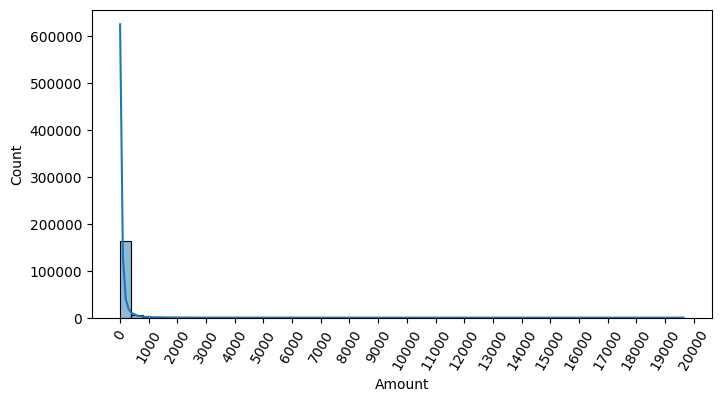

In [16]:
# import matplotlib.pyplot as plt로 초기에 import함
# import seaborn as sns 초기에 import 함

plt.figure(figsize = (8,4))
plt.xticks(range(0,30000,1000), rotation = 60)
sns.histplot(train['Amount'], bins=50, kde = True)
plt.show()

# 이런 경우 생각해 볼 수 있는 transformation은 두 가지가 있음
## log-transformation(통상 밑이 e인 exponential...)
## square-root transformation..

In [17]:
# V1 ~ V28의 관계를 보자.
print(train["V1"].mean(),train["V1"].median()) # -0.16, -0.18
print(train["V2"].mean(),train["V2"].median()) # 0.04, 0.11.. 차이가 좀 있네?

print(f'V1의 왜도:{round(train["V1"].skew(),2)}')
print(f'V2의 왜도:{round(train["V2"].skew(),2)}')

-0.16983800941757618 -0.183560304650246
0.040770586166951256 0.10967913824662
V1의 왜도:-3.44
V2의 왜도:-4.53


In [18]:
# V1~V28 컬럼만 불러와보자
import re # 정규표현식(regular-expression 불러오는 기능! python 자체 내장함수!)

# 'V'로 시작하는 컬럼 이름만 필터링
col_list = [col for col in train.columns if re.match(r'V\d+', col)]

In [19]:
# 일단... 불행하게도
# V1~V28 중에 왜도
skewness_train_list = []
skewness_test_list = []

for col in col_list:
    target = train[col]
    tmp = target.skew()
    skewness_train_list.append(tmp)

for col in col_list:
    target = test[col]
    tmp = target.skew()
    skewness_test_list.append(tmp)

In [20]:
# 연산 위해서 array로 변환
train_skew = np.array(skewness_train_list)
test_skew = np.array(skewness_test_list)

sign_difference = np.sign(train_skew) != np.sign(test_skew) # 다른 걸 찾아보자!
print(sign_difference)

# 불행하게도... train/test set 간의... 왜도(부호를 비교해 보았는데..)
# 다른게 좀 나온다.

# True인 인덱스 위치 찾기
unmatching_columns = np.array(col_list)[sign_difference]

# 결과 출력
print("Columns with matching skew direction:", unmatching_columns)

[False False False False False False  True False False False False False
  True False False False  True False  True  True False False False False
 False False  True False]
Columns with matching skew direction: ['V7' 'V13' 'V17' 'V19' 'V20' 'V27']


In [21]:
print(train_skew[[6,12,16,18,19,26]])

print(test_skew[[6,12,16,18,19,26]])

text = """불행히도.. V7, V13, V17, V19, V20, V27은 train/test set왜도 부호가 반대방향이며
심지어 V7, V17, V20, V27은 train/test 중 적어도 하나 이상의 왜도 절대값이 (-2) 이상임
물론 tree기반 모형이 scaling이 필요 없기는 하지만...... train-set에서 성능이 좋은데,
test-set에서 성능이 나쁜 원인이 될 수도"""

print('\n')
# '\n'을 공백으로 바꾸기
text_no_newline = text.replace("\n", " ")

print(text_no_newline)

[-2.44639364  0.13482484 -5.39610317 -0.02464512  2.31505306 -2.9301537 ]
[ 9.05361957 -0.21283932  0.53405572  0.30761907 -6.32069583  0.97472042]


불행히도.. V7, V13, V17, V19, V20, V27은 train/test set왜도 부호가 반대방향이며 심지어 V7, V17, V20, V27은 train/test 중 적어도 하나 이상의 왜도 절대값이 (-2) 이상임 물론 tree기반 모형이 scaling이 필요 없기는 하지만...... train-set에서 성능이 좋은데, test-set에서 성능이 나쁜 원인이 될 수도


In [22]:
col_data = train[col_list]
corr_matrix = col_data.corr()

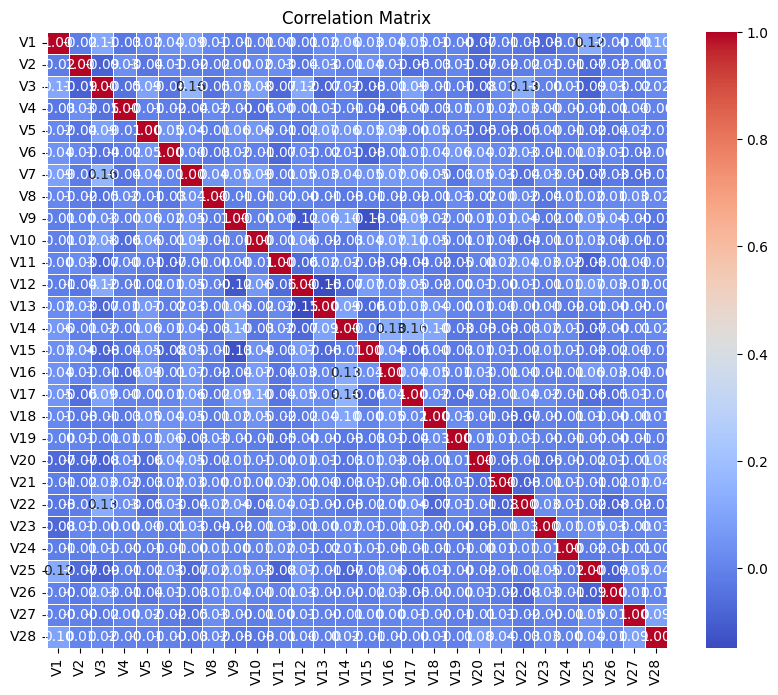

In [23]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix')
plt.show()
# 특별히 다중 공선성 문제는 없어 보임!

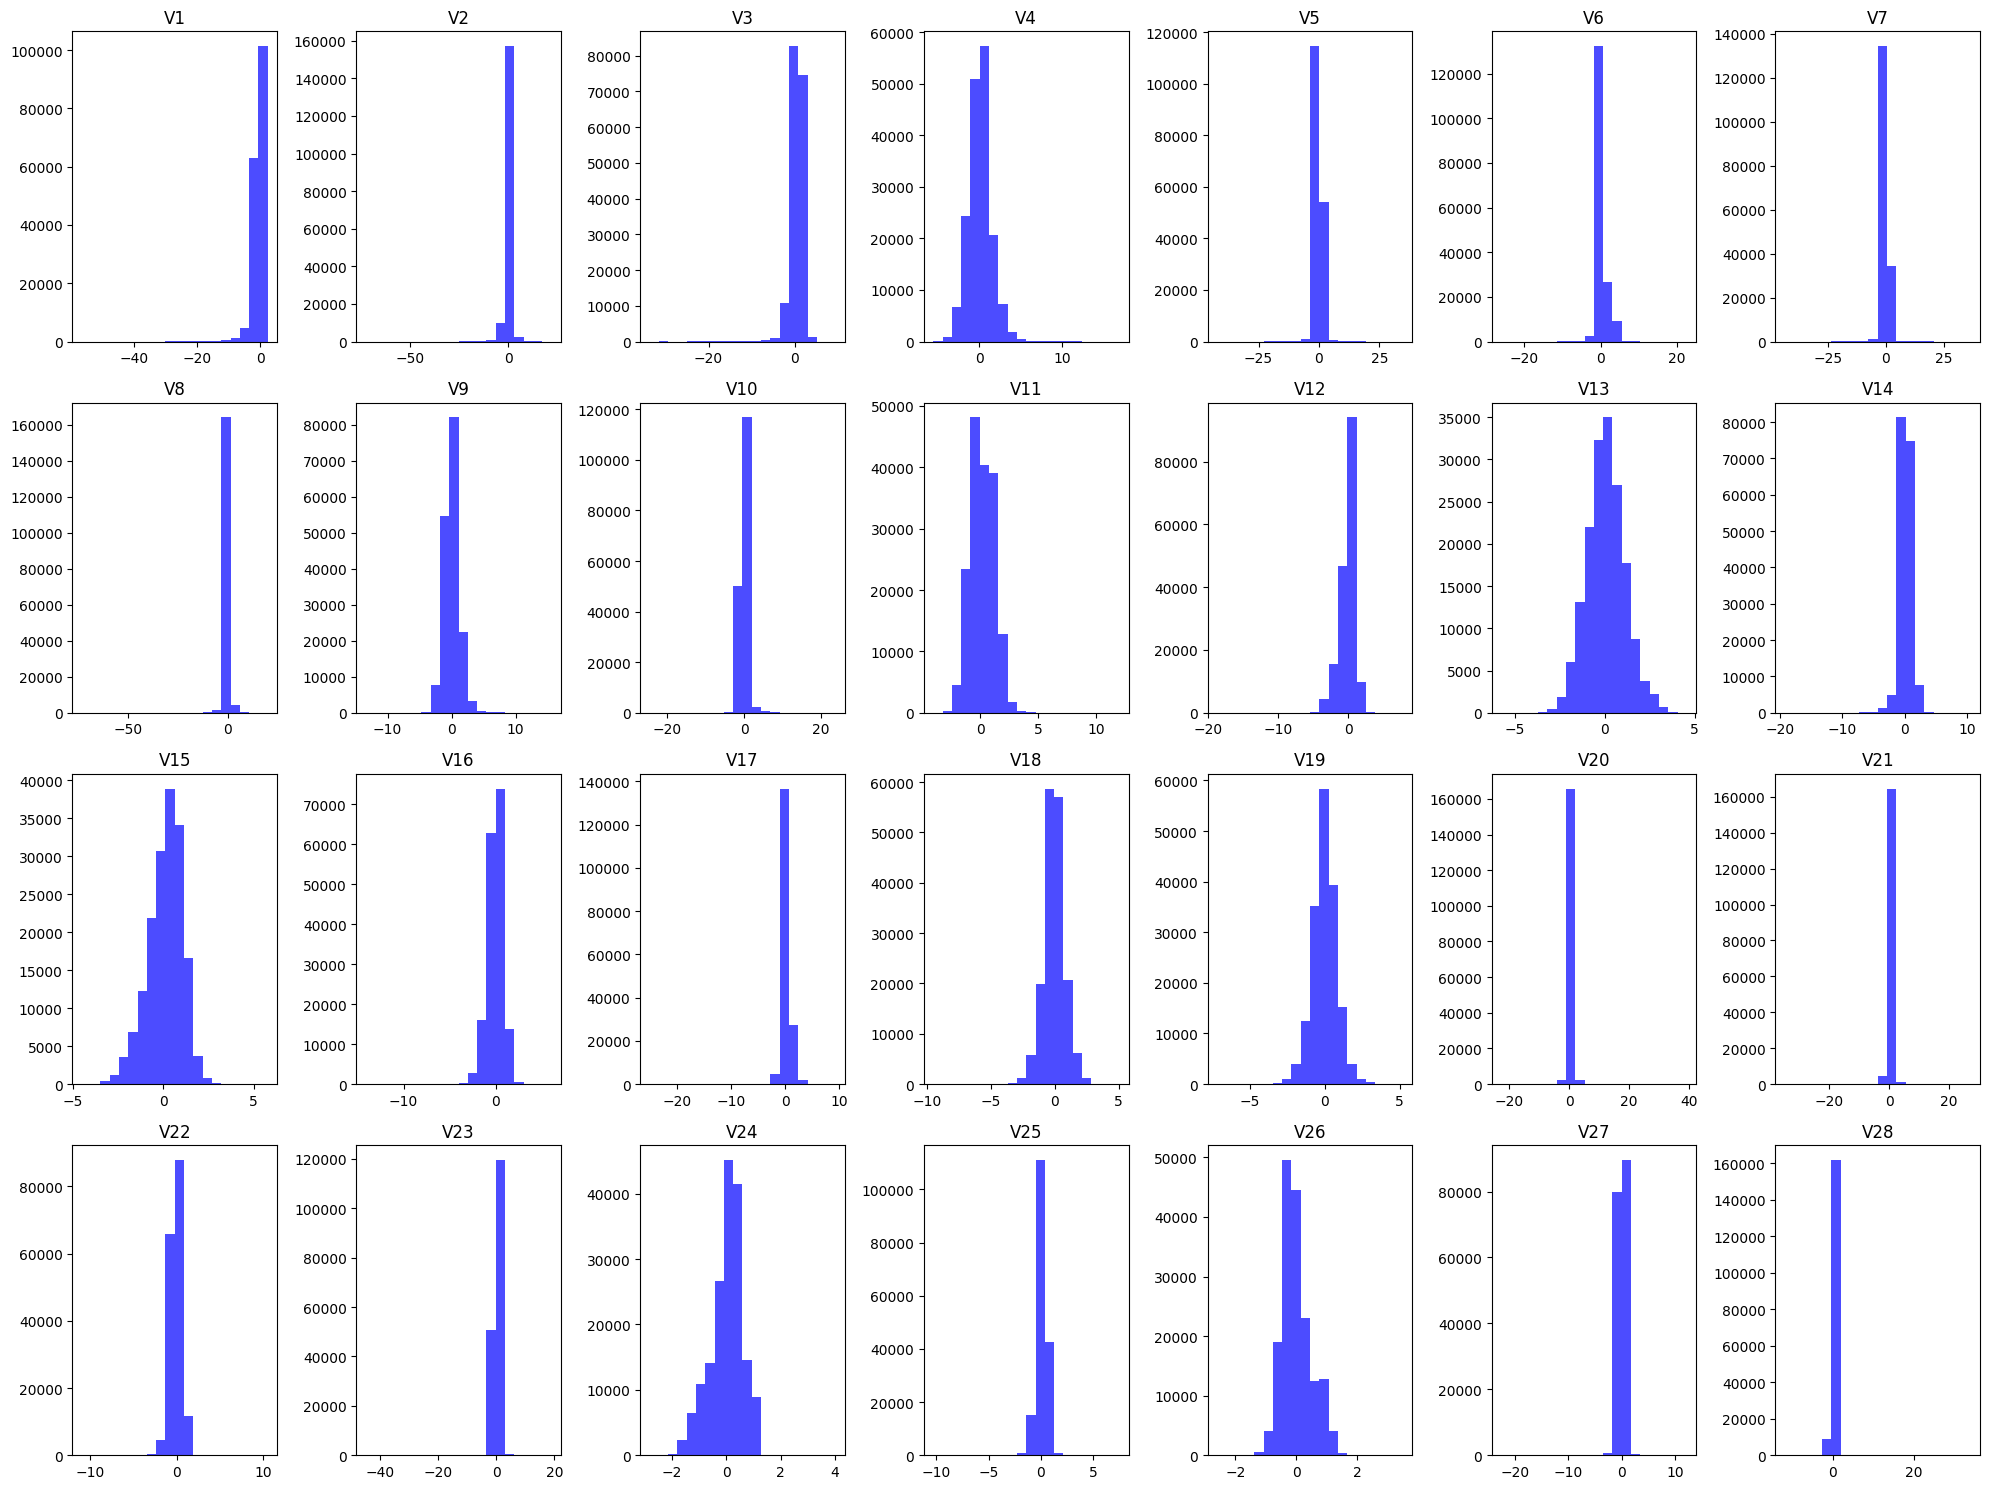

In [24]:
# V1~V28 시각화

import matplotlib.pyplot as plt

# 4x7 subplots 생성
fig, axes = plt.subplots(4, 7, figsize=(20, 15))  # 4행 7열, 크기는 조정 가능
axes = axes.flatten()  # 2D 배열을 1D로 변환하여 쉽게 접근

# 각 변수에 대해 서브플롯에 시각화
for i, col in enumerate(col_list):
    axes[i].hist(train[col], bins=20, alpha=0.7, color='blue')  # 히스토그램
    axes[i].set_title(f'{col}')  # 제목 추가

# 레이아웃 자동 조정
plt.tight_layout()
plt.show()

##### (참고)
- V1~V28, amount등의 train/test가 분포가 동일한지 판별할 필요가 있다는 생각이 들었음
- 일반적으로...... train/test 각각은 분포가 일정할 수 있으나, 시점에 따라서, 상황에 따라 다를 수도 있기 때문
- 그런데, kolmogolov나 U-stat이나 어떤 것을 쓰더라도 수십만건의 데이터를 컬럼별로 분포가 동일한지 계산(의미X)
  - 아무리 비모수 검정이어도, 데이터가 수십만건이면 귀무가설 기각하기 쉬워짐(무조건 다른 분포라 판정)
  - 그리고... 계산하는데 시간, 비용이 많이 들 수 밖에 없음
  - 각 컬럼별로, sampling을 해서 column-wise하게 분포를 비교해 보는 것도 하나의 방법
    - 일반적으로 kolmogolov 등은 sample 수가 5000 넘지 않는걸 권장하나 요즘 trend는 더 조사가 필요

#### 02 데이터 전처리
- 02-01) 이상치 처리
  - 이상치 처리, 가공, 평가, 아웃라이어 함수.. (교재 그대로 활용!)
  - 이상치 처리시, 사기(class=1)의 비율이 0.2% 내외라... outlier를 함부로 제거하기도 애매한 상황!
  - 일단 교재에 있는 기준대로 컬럼 하나에 대해서만 outlier제거
- 02-02) 데이터 전처리
  - 컬럼별, 왜도 고려하여 transformation 적용!(Amount는 log_transformation)
  - 적용 전/후 parameter tuning전의 모델 성능 비교!
- 02-03) 파생변수(feature-engineering?)

In [25]:
def get_preprocessed_df(df=None, train=True):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy["Amount"]) # 로그 변환
    df_copy.insert(0, "Amount_Scaled", amount_n) # "Amount_Scaled컬럼 삽입, 0으로 초기화!"
    df_copy.drop(["Time", "Amount", "id"], axis=1, inplace=True) 
    # pandas에서 범주형 column 제거 시, inplace 안쓰는 방향으로 바뀜
    # pandas' recommendation on inplace deprecation and categorical column
    # 출처 : https://github.com/pandas-dev/pandas/issues/57104
    # 그래서 df_copy가 사용된 듯..
    # train도 transformation 했으면 test도 해야함..!

    # 교재 출판 당시에는 id컬럼이 따로 없었든(모두연에서 출제 목적으로 id컬럼 추가했든)
    # id컬럼도 삭제하는 로직이 있어야 한다.
    # SVC가 아예 안 도는 이유가 있었음(18시 23분...)
    # boosting 계열에서는 id컬럼 들어가는게 영향 안 줄 수 있는데, 여기서는 준 듯 하다!
    # 차라리...주어진 함수를 정확히 이해 못한 거였으면(교과서에서든 뭐든) 그냥 처음부터 짜는게 차라리 나았을듯
    
    outlier_index = get_outlier(df=df_copy, column="V14", weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    
    return df_copy

In [26]:
# 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수

def get_train_test_dataset(df=None):
    df_copy = get_preprocessed_df(df)
    
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]
    
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target,
                                                        test_size=0.3, random_state=0, stratify=y_target)
    
    return X_train, X_test, y_train, y_test

In [27]:
# 평가 함수

def get_clf_eval(y_test, pred, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    
    roc_auc = roc_auc_score(y_test, pred_proba)
    print("오차 행렬")
    print(confusion)
    print(f"정확도: {accuracy:.4f}, 정밀도: {precision: .4f}, 재현율: {recall: .4f}, f1스코어: {f1:.4f}, roc-auc: {roc_auc:.4f}")

In [28]:
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)

In [29]:
def get_outlier(df=None, column=None, weight=1.5):
    fraud = df[df["Class"]==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    return outlier_index

##### 02-01) 이상치 처리
- outlier만 제거해서는 안될 것 같음(class=1)의 수량이 너무 적기 때문!
- 문제는 train/test set 왜도 방향이 다르고 값이 큰 컬럼도 있다는 것(분포가 다르다는 것!)

In [30]:
# outlier 확인해보기
outlier_index = get_outlier(df=train, column="V14", weight=1.5)
# outlier_index = get_outlier(df=train, column="V1", weight=1.5)
outlier_index

Index([8296, 8615, 9035], dtype='int64')

In [31]:
train["Class"].value_counts() # 일단... 17만개 중에 360개 밖에 없어서...
# outlier를 빼는 방향은 가급적 지양하자!

Class
0    170523
1       360
Name: count, dtype: int64

In [69]:
# train_skewness = train[col_list].skew()
# test_skewness = test[col_list].skew() # test(이건 채점용 데이터.. 모델 학습에서의 X_train, X_test랑 다름)
# skewness_df = pd.DataFrame({
#     'Train_Skewness': train_skewness,
#     'Test_Skewness': test_skewness
# })

# # 부호가 다른 컬럼만 필터링
# skewness_diff_sign = skewness_df[skewness_df['Train_Skewness'].apply(np.sign) != skewness_df['Test_Skewness'].apply(np.sign)]

# # 결과 출력 (아까 언급했던 부분!)
# print(skewness_diff_sign)

     Train_Skewness  Test_Skewness
V7        -2.446394       9.053620
V13        0.134825      -0.212839
V17       -5.396103       0.534056
V19       -0.024645       0.307619
V20        2.315053      -6.320696
V27       -2.930154       0.974720


02-02) 데이터 전처리
- 컬럼별, 왜도 고려하여 transformation 적용!(Amount는 log_transformation)
- 적용 전/후 데이터를.. 구분 지어야 하지 않나?


In [32]:
X_train, X_test, y_train, y_test = get_train_test_dataset(train)

In [33]:
X_train.head() # id컬럼 제거 (Amount_Scaled, V1~V28)

,Amount_Scaled,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
168086,4.077537,2.007390,-0.906754,-2.531306,-0.397208,1.956887,3.674065,-0.859827,0.801180,-0.677268,...,-1.416269,-0.498413,-0.017557,0.423003,0.001994,0.692191,0.316705,-0.297782,0.050395,-0.044658
120790,7.500944,-3.626983,-5.592802,-0.914714,-0.410838,-5.208979,2.639078,5.691357,-0.503451,-3.684648,...,0.434038,3.923703,1.035055,0.183115,3.990605,-0.154880,1.191533,0.022764,-0.553519,0.191590
127688,3.696848,1.198164,0.115922,0.328186,0.671532,-0.463145,-0.995986,0.137811,-0.255910,0.027180,...,-0.264461,-0.010290,0.067928,0.178230,-0.112164,0.441026,0.519457,0.424236,-0.039989,0.017876
20736,2.564180,-0.346630,0.688003,0.384736,-2.183807,-0.689107,-1.270980,0.216814,0.140046,0.927728,...,1.247976,-0.091338,0.316672,1.036138,-0.083303,0.485265,-0.063335,-0.685361,-0.107718,-0.023558
132238,2.607124,-0.624860,1.093090,1.723312,-0.183855,0.016031,-0.656731,0.852506,-0.174875,-0.407278,...,0.196659,0.332305,-0.240117,-0.400351,-0.038892,0.527122,-0.208220,0.015917,0.212547,-0.049140


In [34]:
print("학습 데이터 레이블 값 비율")
print(y_train.value_counts()/y_train.shape[0] * 100)
print()
print("테스트 데이터 레이블 값 비율")
print(y_test.value_counts()/y_test.shape[0] * 100)

학습 데이터 레이블 값 비율
Class
0    99.790998
1     0.209002
Name: count, dtype: float64

테스트 데이터 레이블 값 비율
Class
0    99.791277
1     0.208723
Name: count, dtype: float64


##### (참고)
- V1~V28에 대해 왜도에 따라 train/test셋에 대한 변형 적용
- 단 transformed data가 실제 적용될지는 모델 비교해보고 결정

In [76]:
# import numpy as np
# import pandas as pd
# from sklearn.preprocessing import RobustScaler

# # train과 test에서 V1~V28 컬럼만 추출
# col_list = [f'V{i}' for i in range(1, 29)]  # V1~V28 컬럼 # 아까 정의했었음

# # train과 test에서 각 컬럼별 왜도 계산
# train_skewness = train[col_list].skew()
# test_skewness = test[col_list].skew()

# # 변환 적용 함수 정의
# def transform_data(train, test, train_skewness, test_skewness, col_list):
#     transformed_train = train.copy()
#     transformed_test = test.copy()
    
#     # RobustScaler 객체 생성
#     robust_scaler = RobustScaler()

#     # 각 컬럼에 대해 왜도 기준으로 변환 적용
#     for col in col_list:
#         train_skew = train_skewness[col]
#         test_skew = test_skewness[col]
        
#         # 왜도 절대값이 2 이상이면 로그 변환
#         if abs(train_skew) > 2:
#             # 왜도가 양수면 로그(x + 1), 음수면 로그1p(-x)로 변환
#             if train_skew > 0:
#                 transformed_train[col] = np.log1p(train[col])
#                 transformed_test[col] = np.log1p(test[col])
#             else:
#                 transformed_train[col] = np.log1p(-train[col])  # 음수일 경우 로그1p(-x)
#                 transformed_test[col] = np.log1p(-test[col])  # 동일한 변환 적용
#         else:
#             # 왜도 절대값이 2 미만이면 Robust Scaling 적용
#             transformed_train[col] = robust_scaler.fit_transform(train[[col]])
#             transformed_test[col] = robust_scaler.transform(test[[col]])

#     return transformed_train, transformed_test

# # train과 test 데이터에 변환 적용
# transformed_train, transformed_test = transform_data(train, test, train_skewness, test_skewness, col_list)

# # 결과 출력 (첫 5행)
# print(transformed_train.head())
# print(transformed_test.head())


   id  Time        V1        V2        V3        V4        V5        V6  \
0   0   0.0  0.858580  0.070255       NaN  0.745847 -0.093161  0.583184   
1   1   0.0       NaN -0.309452 -0.182098  0.192640  0.237901  0.105472   
2   2   1.0  0.857964  0.850221       NaN  0.151967 -0.230192  1.756628   
3   3   1.0  0.676139  0.169933       NaN -0.587469  0.179452  1.271420   
4   4   2.0  0.769290 -2.101579       NaN  0.165800 -0.150402  0.261815   

         V7        V8  ...       V21       V22       V23       V24       V25  \
0 -0.273909 -0.103915  ... -0.018476  0.378731  0.104787  0.009960 -0.011963   
1  0.075852 -0.088942  ... -0.255893 -0.628487 -0.106793 -0.533624  0.052920   
2 -1.567629 -0.284588  ...  0.221541  0.921449 -2.401436 -1.000582 -0.778151   
3 -0.271296 -0.473909  ... -0.114626  0.079191  0.174223 -1.650431  0.859458   
4 -0.898797  0.239436  ... -0.009475  0.950680  0.128796  0.109302 -0.573861   

        V26       V27       V28  Amount  Class  
0 -0.215735 -0.1433

#### 참고(feature V1~V28에 대해, from Gemini-advanced)
네, 일반적으로 캐글(Kaggle)의 "Credit Card Fraud Detection" 데이터셋에 대한 설명을 보면 V1부터 V28까지의 피처에 대해 다음과 같이 언급되어 있습니다.

"Due to confidentiality issues, the original features and more background information about the data cannot be provided."
(기밀 유지 문제로 인해 원본 피처와 데이터에 대한 더 자세한 배경 정보는 제공될 수 없습니다.)

그리고 이어서, "Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'."
(피처 V1, V2, … V28은 PCA로 얻은 주성분들이며, PCA로 변환되지 않은 유일한 피처는 'Time'과 'Amount'입니다.)

이 설명은 데이터셋을 제공한 연구기관(ULB - Université Libre de Bruxelles, Machine Learning Group)의 원본 설명에서 비롯된 것으로, 캐글의 여러 데이터셋 설명 페이지나 관련 커널(노트북)에서도 동일하게 인용되고 있습니다.

따라서, V1~V28 피처들이 PCA 변환된 값이라는 것은 데이터셋 제공자가 명시한 공식적인 설명입니다. 사용자님의 추측이 맞습니다.

이 정보는 다음과 같은 중요한 점을 시사합니다:

익명성: 민감한 금융 거래 데이터를 보호하기 위해 원본 피처를 직접 공개하는 대신 PCA를 통해 변환된 값을 제공한 것입니다.
차원 축소 및 정보 압축: PCA는 원본 데이터의 분산을 최대한 보존하는 새로운 변수(주성분)들을 생성합니다. 이 과정에서 일부 차원 축소가 이루어졌을 수도 있고, 정보가 압축되었을 수도 있습니다.
스케일링 및 상관관계: PCA를 적용하기 전에는 일반적으로 데이터 스케일링(예: 표준화)을 수행하며, 결과로 나온 주성분들은 서로 직교(uncorrelated)하는 특성을 가집니다.
추가 변환의 불필요성/위험성: 바로 이전 대화에서 논의했듯이, 이미 PCA 변환된 이 V 피처들에 대해 추가적인 복잡한 변환(특히 왜도 기반의 조건부 변환이나 로그 변환)을 적용하는 것은 원래 PCA가 포착한 구조를 왜곡하거나 불필요한 복잡성을 야기할 수 있습니다.
결론적으로, V1~V28 피처가 PCA 변환된 값이라는 것은 널리 알려진 사실이며, 데이터셋 설명에도 명시되어 있는 부분입니다. 이 점을 고려하여 전처리 전략을 세우시는 것이 중요합니다.


In [37]:
X_test.head()

,Amount_Scaled,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
128111,6.728629,-0.274719,-4.271522,0.555945,-0.224656,-3.008913,1.044319,-0.851446,0.259489,-0.647533,...,0.167830,1.208233,0.112520,-0.749947,-0.609307,0.258823,-0.101128,-0.295952,-0.051425,0.158549
137771,3.931826,-0.678615,0.743804,-0.189903,-1.960865,-0.023973,-1.021945,0.763177,0.279871,0.935511,...,0.457796,-0.129163,0.084717,0.319868,-0.137415,-0.468728,0.046492,-0.763216,0.292585,0.171990
16233,4.788824,0.818892,-0.476515,1.191483,2.785386,-0.685982,1.367311,-0.747200,0.570750,0.451659,...,-0.538801,-0.060776,0.132088,0.393537,-0.237981,-0.303600,0.458888,0.238874,0.027903,0.027170
52242,5.652489,0.590225,-0.886851,0.898283,1.445704,-0.990729,0.295527,-0.226116,0.091737,0.646402,...,-0.883011,0.443897,0.328236,0.560192,-0.314293,0.136172,0.359479,-0.260757,0.037350,0.082329
153737,2.638343,-0.065335,1.099988,-0.167482,0.327913,1.456341,-0.297352,1.305708,-0.179538,0.521814,...,-0.341009,-0.278518,0.095407,0.596522,-0.143673,0.637325,-0.393709,-0.750244,0.182983,0.214434


#### 03 모델 선택 및 비교 
- 03-01) 어떤 모델을 쓸까?
  - 01. 로지스틱 : 성공/실패 등 binary-classification에 가장 흔히 쓰일 법한 방법
  - 02. SVC : kernel 함수 적용시 연산 시간 오래 걸리는 'rbf'말고 'linear' 사용해도 될 듯.
    - 정확도: 0.9993, 정밀도:  0.8257, 재현율:  0.8411, f1스코어: 0.8333, roc-auc: 0.9415 (85초)
    - 'id'컬럼 제거하니 정상적으로 연산 됨!
  - 03. 랜덤포레스트 : 앙상블 모델의 대표 방법, overfitting에 강함 (앙상블1?..begging)
  - 04. LightGBM : XG-boost와 성능 비슷하면서, 효율적인 모델 (앙상블2?.. boosting)
  - 05. VotingClassifier : 로지스틱 + 랜덤포레스트 + LightGBM, soft-voting방식 결합
- 결과비교(초기값기준)
  - 로지스틱 : 정확도: 0.9990, 정밀도:  0.8481, 재현율:  0.6262, f1스코어: 0.7204, roc-auc: 0.9666 (0.63초)
  - SVC : 정확도: 0.9993, 정밀도:  0.8257, 재현율:  0.8411, f1스코어: 0.8333, roc-auc: 0.9415(85초)
  - RandomForest : 정확도: 0.9995, 정밀도:  0.9462, 재현율:  0.8224, f1스코어: 0.8800, roc-auc: 0.9515 (110초)
  - LightGBM : 정확도: 0.9996, 정밀도:  0.9474, 재현율:  0.8411, f1스코어: 0.8911, roc-auc: 0.9772 (10초)
  - LightGBM(x변환) : 정확도: 0.9995, 정밀도:  0.9286, 재현율:  0.8426, f1스코어: 0.8835, roc-auc: 0.9789 (10초)
  - VotingClassifier : 정확도: 0.9996, 정밀도:  0.9375, 재현율:  0.8411, f1스코어: 0.8867, roc-auc: 0.9699 (120초)

In [36]:
# 01 로지스틱 #(16초?!)
import time
st = time.time()

lr_clf = LogisticRegression(max_iter=1000)
get_model_train_eval(model = lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

ed = time.time()
print(f'소모시간(로지스틱): {round(ed-st,2)}초')

오차 행렬
[[51145    12]
 [   40    67]]
정확도: 0.9990, 정밀도:  0.8481, 재현율:  0.6262, f1스코어: 0.7204, roc-auc: 0.9666
소모시간(로지스틱): 0.63초


In [79]:
# ## 02 SVC(support vector classifier)
# import time
# from sklearn.svm import SVC
# st = time.time()

# svc_clf = SVC(kernel='linear',C=0.1, probability=True) # 기본값 'rbf'(시간 단축 목적으로 linear kernel 선택)
# # C=1이 기본값인데 0.1로 줄임.. 계산시간 때문
# # probability = True해야.. predict_proba가 나옴
# get_model_train_eval(model = svc_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

# ed = time.time()
# print(f'소모시간(SVC): {round(ed-st,2)}초')

오차 행렬
[[51138    19]
 [   17    90]]
정확도: 0.9993, 정밀도:  0.8257, 재현율:  0.8411, f1스코어: 0.8333, roc-auc: 0.9415
소모시간(SVC): 85.58초


In [80]:
# # 03 RF(Random Forest)

# from sklearn.ensemble import RandomForestClassifier
# st = time.time()

# rf_clf = RandomForestClassifier()
# get_model_train_eval(model = rf_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

# ed = time.time()

# print(f'소모시간(rf_clf): {round(ed-st,2)}초')

오차 행렬
[[51152     5]
 [   19    88]]
정확도: 0.9995, 정밀도:  0.9462, 재현율:  0.8224, f1스코어: 0.8800, roc-auc: 0.9515
소모시간(rf_clf): 107.37초


In [38]:
# 04 LightGBM

st = time.time()
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False, verbose=-1)
# verbose = -1로 지정하면 로그가 최소화되어 나옴!?
get_model_train_eval(model = lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)
ed = time.time()

print(f'소모시간(LightGBM_clf): {round(ed-st,2)}초')

오차 행렬
[[51152     5]
 [   17    90]]
정확도: 0.9996, 정밀도:  0.9474, 재현율:  0.8411, f1스코어: 0.8911, roc-auc: 0.9772
소모시간(LightGBM_clf): 9.66초


In [84]:
## 04-02) LightGBM(transformed-data)
## V1~V28 왜도 변형한 것

# 일단.. 변형된 train데이터 셋을.. train/test로 분할!
# X_train2, X_test2, y_train2, y_test2 = get_train_test_dataset(transformed_train) # 구분해야함! 변수를!(안 꼬이도록!)
# 이거 의미없어서 주석처리함!

In [39]:
# st = time.time()
# lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False, verbose=-1)
# get_model_train_eval(model = lgbm_clf, ftr_train=X_train2, ftr_test=X_test2, tgt_train=y_train2, tgt_test=y_test2)
# ed = time.time()

# print(f'소모시간(LightGBM_clf): {round(ed-st,2)}초')
# print('Skewness(왜도)따른 적용 결과입니다.')

In [40]:
# # 05 VotingClassifier
# # 로지스틱, rf, LightGBM.. Voting으로 soft

# from sklearn.ensemble import VotingClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
# from lightgbm import LGBMClassifier

# st = time.time()

# log_reg = LogisticRegression(random_state=0)
# rf = RandomForestClassifier(n_estimators=100, random_state=0)
# lgbm = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False, verbose=-1)

# # VotingClassifier 정의 (Soft Voting)
# voting_clf = VotingClassifier(estimators=[
#     ('log_reg', log_reg),
#     ('rf', rf),
#     ('lgbm', lgbm)
# ], voting='soft')  # soft voting을 사용

# get_model_train_eval(model = voting_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

# ed = time.time()
# print(f'소모시간(Voting(soft)): {round(ed-st,2)}초')

오차 행렬
[[51151     6]
 [   17    90]]
정확도: 0.9996, 정밀도:  0.9375, 재현율:  0.8411, f1스코어: 0.8867, roc-auc: 0.9699
소모시간(Voting(soft)): 123.28초


#### 04 성능평가!
- 모델 성능만 놓고보면 LightGBM이 가장 좋음
- 데이터 변환(V1~V28..skewness) 관련
  - LightGBM : 정확도: 0.9996, 정밀도:  0.9474, 재현율:  0.8411, f1스코어: 0.8911, roc-auc: 0.9772 (10초)
  - LightGBM(x변환) : 정확도: 0.9995, 정밀도:  0.9286, 재현율:  0.8426, f1스코어: 0.8835, roc-auc: 0.9789 (10초)
- 추가적으로 고려할 만한 전략?
  - (전략1) Hyperparameter tuning
  - (전략2) Oversampling(smote) + Hyperparamter tuning

##### 04-01 parameter tuning
- 일단 LightGBM에서의 parameter tuning
- (전략1) hyperopt 사용해보자
  - 정확도: 0.9996, 정밀도:  0.9293, 재현율:  0.8598, f1스코어: 0.8932, roc-auc: 0.9787 (tuning시간 포함 약 5-6분)
- (전략2) smote algorithm / hyperopt 결합?

In [56]:
# 기존 초기 모델관련 파라미터 값!(참고)
# lgbm_clf.get_params()

# {'boosting_type': 'gbdt',
#  'class_weight': None,
#  'colsample_bytree': 1.0,
#  'importance_type': 'split',
#  'learning_rate': 0.1,
#  'max_depth': -1,
#  'min_child_samples': 20,
#  'min_child_weight': 0.001,
#  'min_split_gain': 0.0,
#  'n_estimators': 1000,
#  'n_jobs': -1,
#  'num_leaves': 64,
#  'objective': None,
#  'random_state': None,
#  'reg_alpha': 0.0,
#  'reg_lambda': 0.0,
#  'subsample': 1.0,
#  'subsample_for_bin': 200000,
#  'subsample_freq': 0,
#  'boost_from_average': False}


##### (참고) LightGBM HyperParameter Setting (ChatGPT에 parameter setting의 convention문의)
- learning_rate: 모델의 학습 속도. 보통 0.01~0.3 범위로 설정합니다
- n_estimators: 트리의 개수. 보통 100~1000 사이에서 설정합니다.
- max_depth: 트리의 최대 깊이. 보통 3~20 범위에서 설정합니다.
- num_leaves: 트리에서 사용되는 최대 리프 노드 수. 보통 31~255 범위에서 설정합니다.
- min_child_samples: 리프에서 최소 샘플 수. 보통 10~100 범위에서 설정합니다.
- min_child_weight: 리프에서 최소 가중치. 보통 0~10 범위에서 설정합니다.
- subsample: 데이터를 샘플링하는 비율. 보통 0.5~1.0 범위에서 설정합니다.
- colsample_bytree: 트리의 각 트리를 학습하는 데 사용할 피처의 비율. 보통 0.5~1.0 범위에서 설정합니다
- reg_alpha: L1 정규화. 0~1 사이로 설정할 수 있습니다.
- reg_lambda: L2 정규화. 0~1 사이로 설정할 수 있습니다.

In [42]:
from hyperopt import hp

lgbm_search_space = {'n_estimators' : hp.quniform('n_estimators',100,1000,10),
                     'num_leaves' : hp.quniform('num_leaves',32,150,5),
                     'max_depth' : hp.quniform('max_depth',5,50,5),
                     'min_child_samples' : hp.quniform('min_child_samples', 10,100,5),
                     'subsample' : hp.uniform('subsample',0.7,1),
                     'learning_rate': hp.uniform('learning_rate', 0.01,0.2), # 학습률!
                     'colsample_bytree': hp.uniform('colsample_bytree',0.5,1), # 0.5~1.0 사이 실수값
                     'reg_alpha': hp.uniform('reg_alpha',0,1), # 0~1 사이 실수값
                     'reg_lambda' : hp.uniform('reg_lambda',0,1) # 0~1 사이 실수값
                     }

##### K-Fold CV(3-Fold) 대신 StratifiedKFold 사용!
- 이 내용도 교재에 있음
- hyperparameter search위해 활용!

In [93]:
# from sklearn.model_selection import KFold
# from sklearn.metrics import roc_auc_score

# # fmin()에서 호출 시 search_space값으로 XGBClassifier 교차 검증 학습 후, -1*roc_auc 평균 값을 반환!

# def objective_func(search_space):
#   lgbm_clf = LGBMClassifier(
#                             early_stopping_round = 30, # 이거 유의!
#                             n_estimators = int(search_space['n_estimators']),
#                             num_leaves = int(search_space['num_leaves']),
#                             max_depth = int(search_space['max_depth']),
#                             min_child_samples = int(search_space['min_child_samples']),
#                             subsample = search_space['subsample'],
#                             learning_rate = search_space['learning_rate'])

#   # 3개 k-fold 방식으로 평가된 roc_auc 지표를 담는 list (f1도 계산해서 담을 수 있지만...지금 문제 목적과는 안 맞으니..)

#   roc_auc_list = []

#   # 3개 k-fold 방식 적용

#   kf = KFold(n_splits = 3)
#   # X_train을 다시 학습과 검증용 데이터로 분리
#   for tr_index, val_index in kf.split(X_train):
#     # kf.split(X_train)으로 추출된 학습과 검증 index값으로 학습과 검증 데이터 셋 분리
#     X_tr, y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
#     X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]

#     # early stopping은 30회로 설정! 추출된 학습과 검증 데이터로 XGBClassifier 학습 수행!
#     lgbm_clf.fit(X_tr, y_tr, eval_set = [(X_tr, y_tr),(X_val,y_val)])

#     # 1로 예측한 확률값 추출 후 roc auc 계산하고 평균 roc auc 계산을 위해 list에 결과값 담음
#     score = roc_auc_score(y_val, lgbm_clf.predict_proba(X_val)[:,1])
#     roc_auc_list.append(score)

#     # 3개 k-fold로 계싼된 roc_auc값의 평균값을 반환하되,
#     #HyperOpt는 목적함수의 최솟값을 위한 입력값을 찾으므로 -1을 곱한 뒤 반환
#     return -1*np.mean(roc_auc_list)

## 불균형이 매우 심각하므로 StratifiedKFold 권장!

In [43]:
from sklearn.model_selection import StratifiedKFold # KFold 대신 StratifiedKFold 사용
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier, early_stopping, log_evaluation # 콜백 함수 import

def objective_func(search_space):

    lgbm_clf = LGBMClassifier(
        n_estimators=int(search_space['n_estimators']),
        num_leaves=int(search_space['num_leaves']),
        max_depth=int(search_space['max_depth']),
        min_child_samples=int(search_space['min_child_samples']),
        subsample=search_space['subsample'],
        learning_rate=search_space['learning_rate'],
        colsample_bytree=search_space['colsample_bytree'], # 튜닝 대상에 추가!
        reg_alpha=search_space['reg_alpha'],             # 튜닝 대상에 추가!
        reg_lambda=search_space['reg_lambda'],           # 튜닝 대상에 추가!
        is_unbalance=True,                            # 불균형 처리 
        boost_from_average=False, 
        objective='binary',       # 명시적으로 설정
        random_state=42,          # 재현성 확보
        n_jobs=-1,
        verbose=-1                # LightGBM 내부 로그 최소화 (아래 verbose 제어와 별개)
    )

    roc_auc_list = []
    # StratifiedKFold 사용 (클래스 비율 유지, shuffle 및 random_state 추가 권장)
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42) 

    for tr_index, val_index in skf.split(X_train, y_train): # X_train, y_train으로 분할
        X_tr, y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
        X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]

        lgbm_clf.fit(X_tr, y_tr, 
                     eval_set=[(X_val, y_val)],
                     callbacks=[
                         early_stopping(stopping_rounds=30, verbose=False), # early_stopping 콜백 사용, 메시지 출력 안 함
                         log_evaluation(period=0) # 반복마다 로그 출력 안 함
                     ])

        score = roc_auc_score(y_val, lgbm_clf.predict_proba(X_val)[:, 1])
        roc_auc_list.append(score)

    # 루프 밖에서 모든 폴드의 평균 점수 반환
    return -1 * np.mean(roc_auc_list)

In [44]:
from hyperopt import fmin, tpe, Trials
import time

st_time = time.time()

trials = Trials()

best = fmin(fn = objective_func, space = lgbm_search_space, algo = tpe.suggest,
            max_evals = 50,
            trials = trials, rstate = np.random.default_rng(seed=30))

ed_time = time.time()

print('best:', best)
print(f'실행 시간 : {round(ed_time - st_time,2)}초')

100%|██████████| 50/50 [04:24<00:00,  5.29s/trial, best loss: -0.9764098926662811]
best: {'colsample_bytree': 0.8041181929075809, 'learning_rate': 0.10164902782740597, 'max_depth': 10.0, 'min_child_samples': 95.0, 'n_estimators': 610.0, 'num_leaves': 80.0, 'reg_alpha': 0.32076510313330053, 'reg_lambda': 0.05838274036590141, 'subsample': 0.9172318308032573}
실행 시간 : 264.75초


In [47]:
# 전략1 (light_gbm에 그냥 hyper-parameter tuning) # tuning에 한 5분 걸림!
# best
# {'learning_rate': 0.02177230222628907,
#  'max_depth': 5.0,
#  'min_child_samples': 55.0,
#  'n_estimators': 480.0,
#  'num_leaves': 85.0,
#  'subsample': 0.8741271097906098}

# stratified K-fold 일 때!
# {'colsample_bytree': 0.8041181929075809,
#  'learning_rate': 0.10164902782740597,
#  'max_depth': 10.0,
#  'min_child_samples': 95.0,
#  'n_estimators': 610.0,
#  'num_leaves': 80.0,
#  'reg_alpha': 0.32076510313330053,
#  'reg_lambda': 0.05838274036590141,
#  'subsample': 0.9172318308032573}



{'colsample_bytree': 0.8041181929075809,
 'learning_rate': 0.10164902782740597,
 'max_depth': 10.0,
 'min_child_samples': 95.0,
 'n_estimators': 610.0,
 'num_leaves': 80.0,
 'reg_alpha': 0.32076510313330053,
 'reg_lambda': 0.05838274036590141,
 'subsample': 0.9172318308032573}

In [ ]:
best_parameter = {'colsample_bytree': 0.8041181929075809,
 'learning_rate': 0.10164902782740597,
 'max_depth': 10.0,
 'min_child_samples': 95.0,
 'n_estimators': 610.0,
 'num_leaves': 80.0,
 'reg_alpha': 0.32076510313330053,
 'reg_lambda': 0.05838274036590141,
 'subsample': 0.9172318308032573}

In [49]:
## 최적화 전략1
st = time.time()

lgbm_best1 = LGBMClassifier(
    n_estimators=int(610.0),        # 정수형으로 변환
    learning_rate=0.10164902782740597,
    max_depth=int(10.0),              # 정수형으로 변환
    num_leaves=int(80.0),            # 정수형으로 변환
    min_child_samples=int(95.0),# 정수형으로 변환
    subsample=0.9172318308032573,
    colsample_bytree=0.8041181929075809,
    reg_alpha=0.32076510313330053,
    reg_lambda=0.05838274036590141,
    
    # objective_func에서 사용했던 다른 고정 파라미터들도 일관성을 위해 추가
    objective='binary',                            # 예: 이진 분류
    boost_from_average=False,                      # Hyperopt objective_func와 일치
    is_unbalance=True,                             # Hyperopt objective_func와 일치 (또는 여기서도 튜닝 대상이었다면 best에서 가져옴)
    random_state=42,                               # 재현성
    n_jobs=-1,                                     # 모든 코어 사용
    verbose=-1                                     # LightGBM 내부 로그 최소화
)

get_model_train_eval(model = lgbm_best1, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)
ed = time.time()

print(f'소모시간(LightGBM_최적화1): {round(ed-st,2)}초')
print('LightGBM_최적화전략1 결과입니다.')

오차 행렬
[[51150     7]
 [   15    92]]
정확도: 0.9996, 정밀도:  0.9293, 재현율:  0.8598, f1스코어: 0.8932, roc-auc: 0.9787
소모시간(LightGBM_최적화1): 4.75초
LightGBM_최적화전략1 결과입니다.


In [ ]:
# # # 앞에서도 정의한 부분!
# smote = SMOTE(random_state=0)
# X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

In [109]:
from hyperopt import hp

lgbm_search_space2 = {'n_estimators' : hp.quniform('n_estimators',100,1000,10),
                      'num_leaves' : hp.quniform('num_leaves',32,150,5),
                      'max_depth' : hp.quniform('max_depth',5,50,5),
                      'min_child_samples' : hp.quniform('min_child_samples', 10,100,5),
                      'subsample' : hp.uniform('subsample',0.7,1),
                      'learning_rate': hp.uniform('learning_rate', 0.01,0.2),
                      'colsample_bytree': hp.uniform('colsample_bytree',0.5,1),
                      'reg_alpha': hp.uniform('reg_alpha',0,1),
                      'reg_lambda' : hp.uniform('reg_lambda',0,1)
                     }

In [110]:
from imblearn.over_sampling import SMOTE # SMOTE import
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier, early_stopping, log_evaluation

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

def objective_func_smote(search_space):
    lgbm_params = {
        'n_estimators': int(search_space['n_estimators']),
        'num_leaves': int(search_space['num_leaves']),
        'max_depth': int(search_space['max_depth']),
        'min_child_samples': int(search_space['min_child_samples']),
        'subsample': search_space['subsample'],
        'learning_rate': search_space['learning_rate'],
        'colsample_bytree': search_space.get('colsample_bytree', 1.0),
        'reg_alpha': search_space.get('reg_alpha', 0.0),
        'reg_lambda': search_space.get('reg_lambda', 0.0),
        'is_unbalance': False, # SMOTE를 사용하므로 False로 설정
        'boost_from_average': False,
        'objective': 'binary',
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1
    }
    # scale_pos_weight는 lgbm_search_space2에 없으므로, 아래 코드는 실행되지 않거나 scale_pos_weight가 lgbm_params에 없음
    # 만약 scale_pos_weight를 튜닝 대상에 추가한다면 이 로직은 유효
    if 'scale_pos_weight' in search_space:
        lgbm_params['scale_pos_weight'] = search_space['scale_pos_weight']
    # else: # search_space에 scale_pos_weight가 없다면 lgbm_params에 포함되지 않음 (LGBMClassifier 기본값 사용)
    #     pass

    lgbm_clf = LGBMClassifier(**lgbm_params)

    roc_auc_list = []
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=123) # random_state 일관성 유지

    # X_train, y_train은 원본 불균형 학습 데이터를 참조해야 합니다.
    for tr_index, val_index in skf.split(X_train, y_train):
        X_tr, y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
        X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]

        smote_cv = SMOTE(random_state=42) # 각 폴드마다 SMOTE 적용 (random_state는 재현성 위해 고정)
        X_tr_oversampled, y_tr_oversampled = smote_cv.fit_resample(X_tr, y_tr)

        lgbm_clf.fit(X_tr_oversampled, y_tr_oversampled,
                     eval_set=[(X_val, y_val)],
                     callbacks=[
                         early_stopping(stopping_rounds=30, verbose=False),
                         log_evaluation(period=0)
                     ])

        score = roc_auc_score(y_val, lgbm_clf.predict_proba(X_val)[:, 1])
        roc_auc_list.append(score)
    
    return -1 * np.mean(roc_auc_list)


# fmin 호출 시
# best = fmin(fn=objective_func_smote, space=lgbm_search_space, ...)
# 이 때 objective_func_smote가 접근할 X_train_original, y_train_original을 준비해야 함

In [111]:
# from hyperopt import fmin, tpe, Trials
# import time

# st_time = time.time()

# trials = Trials()

# best2 = fmin(fn=objective_func_smote,  
#              space=lgbm_search_space2,
#              algo=tpe.suggest,
#              max_evals=50,
#              trials=trials,
#              rstate=np.random.default_rng(seed=30))

# ed_time = time.time()

# print('best:', best)
# print(f'실행 시간 : {round(ed_time - st_time,2)}초')

100%|██████████| 50/50 [09:15<00:00, 11.12s/trial, best loss: -0.9821706167390327]
best: {'colsample_bytree': 0.8041181929075809, 'learning_rate': 0.10164902782740597, 'max_depth': 10.0, 'min_child_samples': 95.0, 'n_estimators': 610.0, 'num_leaves': 80.0, 'reg_alpha': 0.32076510313330053, 'reg_lambda': 0.05838274036590141, 'subsample': 0.9172318308032573}
실행 시간 : 555.79초


In [112]:
# best2
# {'colsample_bytree': 0.7310507876396988,
#  'learning_rate': 0.1402091580941699,
#  'max_depth': 50.0,
#  'min_child_samples': 50.0,
#  'n_estimators': 150.0,
#  'num_leaves': 100.0,
#  'reg_alpha': 0.06701212845055904,
#  'reg_lambda': 0.06093338018366136,
#  'subsample': 0.8933559450935007}

{'colsample_bytree': 0.7310507876396988,
 'learning_rate': 0.1402091580941699,
 'max_depth': 50.0,
 'min_child_samples': 50.0,
 'n_estimators': 150.0,
 'num_leaves': 100.0,
 'reg_alpha': 0.06701212845055904,
 'reg_lambda': 0.06093338018366136,
 'subsample': 0.8933559450935007}

In [132]:
## 최적화 전략2
st = time.time()

lgbm_best2 = LGBMClassifier(
    n_estimators=int(150.0),        # 정수형으로 변환
    learning_rate=0.1402091580941699,
    max_depth=int(50.0),              # 정수형으로 변환
    num_leaves=int(100.0),            # 정수형으로 변환
    min_child_samples=int(50.0),# 정수형으로 변환
    subsample=0.8933559450935007,
    colsample_bytree=0.7310507876396988,
    reg_alpha=0.06701212845055904,
    reg_lambda=0.06093338018366136,
    
    # objective_func에서 사용했던 다른 고정 파라미터들도 일관성을 위해 추가
    objective='binary',                            # 예: 이진 분류
    boost_from_average=False,                      # Hyperopt objective_func와 일치
    is_unbalance=True,                             # Hyperopt objective_func와 일치 (또는 여기서도 튜닝 대상이었다면 best에서 가져옴)
    random_state=42,                               # 재현성
    n_jobs=-1,                                     # 모든 코어 사용
    verbose=-1                                     # LightGBM 내부 로그 최소화
)

get_model_train_eval(model = lgbm_best2, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)
ed = time.time()

print(f'소모시간(LightGBM_최적화1): {round(ed-st,2)}초')
print('LightGBM_최적화전략2 결과입니다.')

오차 행렬
[[51147    10]
 [   16    91]]
정확도: 0.9995, 정밀도:  0.9010, 재현율:  0.8505, f1스코어: 0.8750, roc-auc: 0.9800
소모시간(LightGBM_최적화1): 2.37초
LightGBM_최적화전략2 결과입니다.


### 제출 준비!

In [143]:
submission = pd.read_csv("/kaggle/input/modu-ds-4-credit-card-fraud-detection/sample_submission.csv")

In [144]:
submission.head()

,id,Class
0,170883,0
1,170884,0
2,170885,0
3,170886,0
4,170887,0


In [79]:
# submission['Class'].value_counts()

Class
0    113923
Name: count, dtype: int64

In [145]:
test["Amount_Scaled"] = np.log1p(test["Amount"])

In [146]:
test.drop(["Time", "Amount"], axis=1, inplace=True) # Time, Amount 제거! (Amount_scaled기준으로 변수 들어가므로)

In [147]:
test.head()

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount_Scaled
0,170883,-2.410892,-1.264333,-0.787460,-0.212152,1.139859,-2.030200,0.533818,-0.194852,-2.277774,...,-0.558831,-0.076699,0.054816,-1.243901,0.147148,0.974330,1.309377,0.083660,-0.611166,4.836123
1,170884,-1.394526,0.284790,2.979226,0.362345,-1.344546,2.278858,-1.836101,-1.797895,0.529802,...,-0.807798,1.945416,-0.539926,-0.446763,-0.521142,0.405680,-0.149237,0.458944,-0.071516,3.931826
2,170885,0.140378,0.989574,-0.506447,0.480553,1.407763,0.371637,0.811775,0.067702,-0.648266,...,0.120841,0.385872,1.302941,-0.177157,-0.192410,-0.724567,-0.433276,0.540947,0.323866,2.271094
3,170886,-1.303150,0.187865,0.944395,-1.277834,1.236744,-1.301696,1.402234,-0.558914,-0.041604,...,-0.251346,-0.274175,-0.656826,-0.164985,0.001284,-0.001842,-0.024050,-0.436872,0.051705,4.110710
4,170887,1.947883,-1.095332,-1.392121,-0.600598,-0.320840,0.048953,-0.443486,-0.081011,-0.634128,...,-0.293448,-0.250594,-0.385151,0.099030,0.221922,-0.212846,0.586637,-0.071616,-0.045475,4.795543


In [148]:
test_feature = test.drop(['id'], axis=1) # feature만 있어야 함!
test_feature.head()


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount_Scaled
0,-2.410892,-1.264333,-0.787460,-0.212152,1.139859,-2.030200,0.533818,-0.194852,-2.277774,0.310404,...,-0.558831,-0.076699,0.054816,-1.243901,0.147148,0.974330,1.309377,0.083660,-0.611166,4.836123
1,-1.394526,0.284790,2.979226,0.362345,-1.344546,2.278858,-1.836101,-1.797895,0.529802,0.776728,...,-0.807798,1.945416,-0.539926,-0.446763,-0.521142,0.405680,-0.149237,0.458944,-0.071516,3.931826
2,0.140378,0.989574,-0.506447,0.480553,1.407763,0.371637,0.811775,0.067702,-0.648266,0.376802,...,0.120841,0.385872,1.302941,-0.177157,-0.192410,-0.724567,-0.433276,0.540947,0.323866,2.271094
3,-1.303150,0.187865,0.944395,-1.277834,1.236744,-1.301696,1.402234,-0.558914,-0.041604,-0.694289,...,-0.251346,-0.274175,-0.656826,-0.164985,0.001284,-0.001842,-0.024050,-0.436872,0.051705,4.110710
4,1.947883,-1.095332,-1.392121,-0.600598,-0.320840,0.048953,-0.443486,-0.081011,-0.634128,0.975375,...,-0.293448,-0.250594,-0.385151,0.099030,0.221922,-0.212846,0.586637,-0.071616,-0.045475,4.795543


In [149]:
id_test = test['id']
id_test.head()

0    170883
1    170884
2    170885
3    170886
4    170887
Name: id, dtype: int64

In [57]:
#lgbm_pred = lgbm_best1.predict(test_feature)

In [150]:
lgbm_pred = lgbm_best2.predict(test_feature)

In [151]:
# unique_values, counts = np.unique(lgbm_pred, return_counts=True)
# print("고유값:", unique_values)
# print("각 고유값의 개수:", counts)

고유값: [0]
각 고유값의 개수: [113923]


In [152]:
lgbm_pred_proba = lgbm_best1.predict_proba(test_feature)

In [84]:
# id_test

0         170883
1         170884
2         170885
3         170886
4         170887
           ...  
113918    284801
113919    284802
113920    284803
113921    284804
113922    284805
Name: id, Length: 113923, dtype: int64

In [153]:
lgbm_pred_proba[:, 1]

array([3.18786015e-06, 2.23290217e-05, 3.69693869e-05, ...,
       1.65840289e-05, 5.83338933e-07, 3.61088997e-06])

In [154]:
# 사실.. 확률값?! 있어야 ROC-AUC 계산 가능?!
results = pd.DataFrame({
    'id': id_test,
    'Class': lgbm_pred_proba[:, 1]
})

In [87]:
# print(f"Length of id_test: {len(id_test)}")
# print(f"Length of lgbm_pred_proba: {len(lgbm_pred_proba)}")

Length of id_test: 113923
Length of lgbm_pred_proba: 113923


In [155]:
test = results # results 결과값 test 할당?
test.head()

,id,Class
0,170883,0.000003
1,170884,0.000022
2,170885,0.000037
3,170886,0.000082
4,170887,0.000005


In [156]:
test["Class"] = lgbm_pred_proba[:, 1] # ROC_AUC가 계산 목적이면 확률값 제출!

In [94]:
# submission['Class'].value_counts()

In [157]:
del submission["Class"]


In [ ]:
# test["Class"] = lgbm_pred  # 범주형이 답이라면 F1-score등?!

In [93]:
# submission.head()

In [158]:
submission = submission.merge(test[["id", "Class"]], on="id")

In [159]:
submission.to_csv("./submission.csv", index=False)